In [10]:
import pandas as pd
import numpy as np
import re
import os


In [11]:
#define as regular expression for each category
strawberries_pattern = r"\b(fresh_strawberry)"
pomegranates_pattern = r"\b(fresh_pomegranate)"
peaches_pattern = r"\b(fresh_peach)"



# Define a function to categorize food based on the filename
def categorize_fruit(item):
    if re.search(strawberries_pattern, item, re.IGNORECASE):
        return 'Strawberries'
    elif re.search(pomegranates_pattern, item, re.IGNORECASE):
        return 'Pomegranates'
    elif re.search(peaches_pattern, item, re.IGNORECASE):
        return 'Peaches'


In [12]:
#where all the files are located
data_path = '/content/drive/MyDrive/fruits'

In [13]:
#looping through all the filename to get the category
data = []

for filename in os.listdir(data_path):
  category = categorize_fruit(filename)
  data.append([filename, category])

In [14]:
data

[['fresh_peach_105.jpg', 'Peaches'],
 ['fresh_peach_108.jpg', 'Peaches'],
 ['fresh_peach_102.jpg', 'Peaches'],
 ['fresh_peach_106.jpg', 'Peaches'],
 ['fresh_peach_104.jpg', 'Peaches'],
 ['fresh_peach_103.jpg', 'Peaches'],
 ['fresh_peach_1.jpg', 'Peaches'],
 ['fresh_peach_10.jpg', 'Peaches'],
 ['fresh_peach_100.jpg', 'Peaches'],
 ['fresh_peach_107.jpg', 'Peaches'],
 ['fresh_peach_101.jpg', 'Peaches'],
 ['fresh_pomegranate_64.jpg', 'Pomegranates'],
 ['fresh_strawberry_226.jpg', 'Strawberries'],
 ['fresh_pomegranate_7.jpg', 'Pomegranates'],
 ['fresh_pomegranate_91.jpg', 'Pomegranates'],
 ['fresh_strawberry_73.jpg', 'Strawberries'],
 ['fresh_strawberry_189.jpg', 'Strawberries'],
 ['fresh_pomegranate_21.jpg', 'Pomegranates'],
 ['fresh_strawberry_43.jpg', 'Strawberries'],
 ['fresh_strawberry_237.jpg', 'Strawberries'],
 ['fresh_strawberry_158.jpg', 'Strawberries'],
 ['fresh_pomegranate_172.jpg', 'Pomegranates'],
 ['fresh_pomegranate_34.jpg', 'Pomegranates'],
 ['fresh_strawberry_249.jpg', 'Str

In [15]:
#converting it to a dataframe
df = pd.DataFrame(data, columns = ['Filename', 'Category'])

In [16]:
df.head()

,Filename,Category
0,fresh_peach_105.jpg,Peaches
1,fresh_peach_108.jpg,Peaches
2,fresh_peach_102.jpg,Peaches
3,fresh_peach_106.jpg,Peaches
4,fresh_peach_104.jpg,Peaches


In [17]:
df.Category.value_counts()

Pomegranates    311
Peaches         250
Strawberries    250
Name: Category, dtype: int64

In [18]:
df.Category.unique()

array(['Peaches', 'Pomegranates', 'Strawberries'], dtype=object)

####**Image PreProcessing**

In [20]:
#necessary libraries
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [21]:
images_dir = data_path

In [22]:
# data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)

In [23]:
# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df,
    directory=images_dir,  # replace with your actual images directory
    x_col='Filename',
    y_col='Category',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='training',
    seed = 42)


validation_generator = train_datagen.flow_from_dataframe(
    dataframe=df,
    directory=images_dir,  # replace with your actual images directory
    x_col='Filename',
    y_col='Category',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='validation',
    seed = 42)

Found 649 validated image filenames belonging to 3 classes.
Found 162 validated image filenames belonging to 3 classes.


In [24]:
train_generator

####**Model Configuration**

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Dropout

In [26]:
#the CNN configuration
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation='softmax')
])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 64)        0

In [28]:
#compiling the model before training
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#### **Training the Model**

In [29]:
#training the model
history = model.fit(
    train_generator,
    epochs = 10,
    validation_data = validation_generator
)

Epoch 1/10
41/41 [==============================] - 608s 15s/step - loss: 1.1309 - accuracy: 0.3421 - val_loss: 1.0215 - val_accuracy: 0.3519
Epoch 2/10
41/41 [==============================] - 49s 1s/step - loss: 0.9014 - accuracy: 0.5824 - val_loss: 0.7697 - val_accuracy: 0.5432
Epoch 3/10
41/41 [==============================] - 51s 1s/step - loss: 0.7456 - accuracy: 0.6703 - val_loss: 0.6038 - val_accuracy: 0.7840
Epoch 4/10
41/41 [==============================] - 47s 1s/step - loss: 0.6065 - accuracy: 0.7766 - val_loss: 0.5099 - val_accuracy: 0.8148
Epoch 5/10
41/41 [==============================] - 50s 1s/step - loss: 0.6710 - accuracy: 0.7381 - val_loss: 0.5894 - val_accuracy: 0.7963
Epoch 6/10
41/41 [==============================] - 45s 1s/step - loss: 0.5285 - accuracy: 0.8305 - val_loss: 0.4902 - val_accuracy: 0.7531
Epoch 7/10
41/41 [==============================] - 46s 1s/step - loss: 0.5084 - accuracy: 0.8105 - val_loss: 0.3906 - val_accuracy: 0.8519
Epoch 8/10
41/41 [

#### **Model Evaluation**

In [30]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation loss: {val_loss}")
print(f"Validation accuracy: {int(val_accuracy* 100)}")

11/11 [==============================] - 7s 589ms/step - loss: 0.4358 - accuracy: 0.8086
Validation loss: 0.4357718527317047
Validation accuracy: 80


In [31]:
from tensorflow.keras.preprocessing import image
import numpy as np

def predict_image_category(image_path, model):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    img_preprocessed = img_array_expanded_dims / 255.0

    # Make a prediction
    prediction = model.predict(img_preprocessed)

    # Assuming your model's classes are accessible via train_generator.class_indices
    # which is a dictionary mapping class names to their indices.
    # We need to invert this dictionary to map indices back to class names.
    label_map = dict((v, k) for k, v in train_generator.class_indices.items())

    # Find the index of the maximum score in the prediction array
    predicted_class_index = np.argmax(prediction, axis=1)
    predicted_class_name = label_map[predicted_class_index[0]]

    return predicted_class_name

# # Example usage
# image_path = 'path/to/your/image.jpg'
# predicted_category = predict_image_category(image_path, model)
# print(f"The predicted category is: {predicted_category}")

In [32]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def display_image_with_prediction(image_path, model):
    # Predict the image category
    predicted_category = predict_image_category(image_path, model)

    # Load the image for display
    img = image.load_img(image_path)

    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Turn off axis numbers and ticks

    # Add a rectangle for the text background, if desired
    plt.gca().add_patch(Rectangle((0, 0), 120, 30, color='white'))

    # Add the predicted category text
    plt.text(5, 20, predicted_category, color='red', weight='bold', fontsize=20)

    plt.show()

In [33]:
# new_model = data_path + '/fruit_model.h5'

1/1 [==============================] - 0s 226ms/step


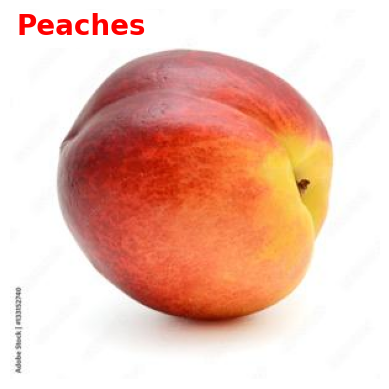

In [34]:
# Example usage
image_path = '/content/drive/MyDrive/fruits/fresh_peach_1.jpg'
display_image_with_prediction(image_path, model)

1/1 [==============================] - 0s 44ms/step


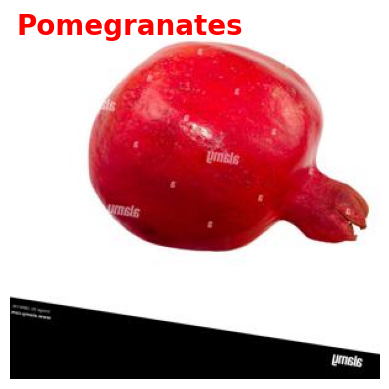

In [35]:
# Example usage
image_path = '/content/drive/MyDrive/fruits/fresh_pomegranate_134.jpg'
display_image_with_prediction(image_path, model)

1/1 [==============================] - 0s 42ms/step


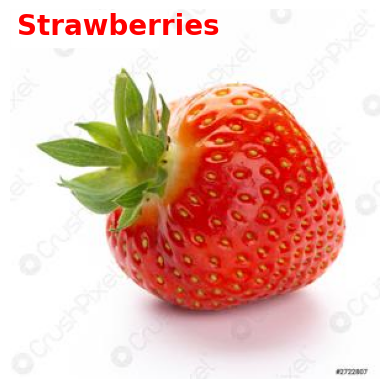

In [36]:
# Example usage
image_path = '/content/drive/MyDrive/fruits/fresh_strawberry_98.jpg'
display_image_with_prediction(image_path, model)

In [37]:
# #saving our custom trained model to Shittu Adedayo Assignment
# model_save_path = data_path + '/fruit_model.h5'
# model.save(model_save_path)

# model_save_path

1/1 [==============================] - 0s 53ms/step


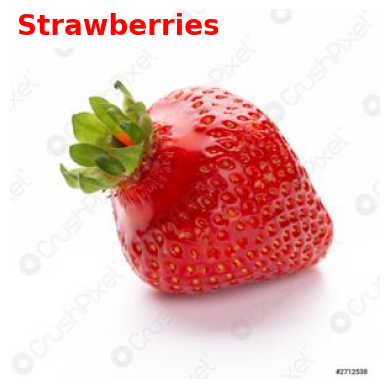

In [38]:
# Example usage
image_path = '/content/drive/MyDrive/fruits/fresh_strawberry_97.jpg'
display_image_with_prediction(image_path, model)

1/1 [==============================] - 0s 37ms/step


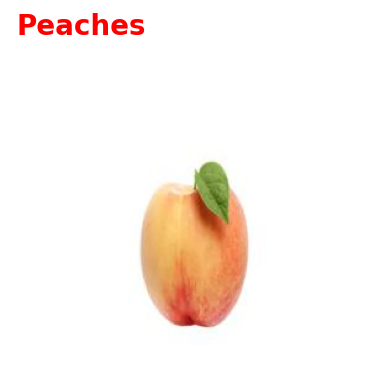

In [39]:
image_path = '/content/drive/MyDrive/fruits/fresh_peach_64.jpg'
display_image_with_prediction(image_path, model)

1/1 [==============================] - 0s 68ms/step


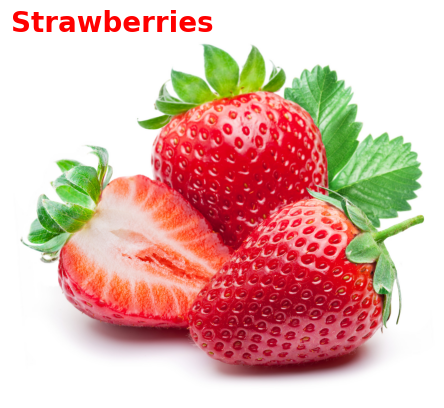

In [40]:
image_path = '/Strawberry testing.jpeg'
display_image_with_prediction(image_path, model)

1/1 [==============================] - 0s 57ms/step


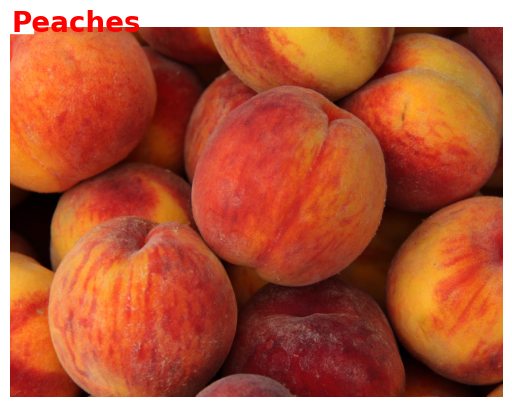

In [41]:
image_path = '/peaches Test.jpeg'
display_image_with_prediction(image_path, model)